In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

ModuleNotFoundError: No module named 'pydub'

if input is 44100 Hz (or 44100 Hertz). This means the microphone gives us 44100 numbers per second. Thus, a 10 second audio clip is represented by 441000 numbers (=  10×4410010×44100 ).

In [4]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [5]:
Ty = 1375 # The number of time steps in the output of our model

## 1.4 - Full training set

You've now implemented the code needed to generate a single training example. We used this process to generate a large training set. To save time, we've already generated a set of training examples. 

In [6]:
# Load preprocessed training examples
X = np.load("X.npy")
Y = np.load("Y.npy")

In [7]:
# Load preprocessed dev set examples
X_dev = np.load("X_dev.npy")
Y_dev = np.load("Y_dev.npy")

# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


<img src="activations.png" style="width:600px;height:600px;">

## 2.1 - Build the model

Here is the architecture we will use. Take some time to look over the model and see if it makes sense. 

<img src="model1.png" style="width:600px;height:600px;">



In [9]:
def model(input_shape):  
    X_input = Input(shape = input_shape)

    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout 

    X = GRU(units = 128, return_sequences = True)(X)                            # GRU ( 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout 
    X = BatchNormalization()(X)                                 # Batch normalization
    
  
    X = GRU(units = 128, return_sequences = True)(X)                                 # GRU ( 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                     # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout ( 0.8)
  
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [10]:
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
__________

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

## 2.2 - Fit the model

Trigger word detection takes a long time to train. To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. Let's load the model. 

In [12]:
model = load_model('tr_model.h5')

C:\Users\piyus\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [13]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [14]:
model.fit(X, Y, batch_size = 5, epochs=1)

Epoch 1/1
26/26 [==============================] - 12s 466ms/step - loss: 0.0513 - acc: 0.9833


## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [15]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

25/25 [==============================] - 2s 66ms/step
Dev set accuracy =  0.9408581852912903


# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [16]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

Once you've estimated the probability of having detected the word "activate" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. Further, $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. So we will insert a chime sound at most once every 75 output steps. This will help prevent us from inserting two chimes for a single instance of "activate". (This plays a role similar to non-max suppression from computer vision.) 

<!-- 
**Exercise**: Implement chime_on_activate(). You will need to do the following:

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 75 consecutive time steps have passed, insert a "chime" sound onto the original audio clip

Use this code to convert from the 1,375 step discretization to the 10,000 step discretization and insert a "chime" using pydub:

` audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio.duration_seconds)*1000)
`
!--> 

In [42]:
chime_file = "chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Loop over the output steps in the y
    for i in range(Ty):
        # Increment consecutive output steps
        consecutive_timesteps += 1
        #  If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

## 3.3 - Test on dev examples

Let's explore how our model performs on two unseen audio clips from the development set. Lets first listen to the two dev set clips. 

In [48]:
IPython.display.Audio("1_dev.wav")

In [44]:
IPython.display.Audio("2_dev.wav")

Now lets run the model on these audio clips and see if it adds a chime after "activate"!

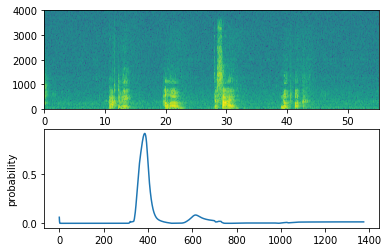

In [52]:
filename = "1_dev.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("chime_output.wav")

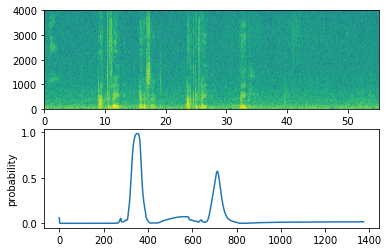

In [53]:
filename  = "2_dev.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("chime_output.wav")